In [2]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [3]:
#Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

In [4]:
#Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

#Emotions to observe
# observed_emotions=['calm', 'happy', 'fearful', 'angry','disgust','surprised','sad','neutral']
observed_emotions=['sad', 'happy', 'neutral', 'angry']

In [5]:
#Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("dataset/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
        
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)


In [6]:
#Split the dataset
x_train,x_test,y_train,y_test=load_data(test_size=0.2)

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
# get models
# get a voting ensemble of models
# define the base models
models = list()

# decision_tree = Pipeline([('m', DecisionTreeClassifier())])
# models.append(('decision', decision_tree))

# neigh = Pipeline([('m',KNeighborsClassifier(n_neighbors = 4))])
# models.append(('knn',neigh))

randomforest = RandomForestClassifier(n_estimators = 100, random_state = 0)
models.append(('randomforest', randomforest))

# svc =  SVC(kernel = 'linear', C = 1)
# models.append(('svc', svc))

# clf = Pipeline([('m',MLPClassifier(random_state=1, max_iter=300))])
# models.append(('mlp',clf))
# logistic = Pipeline([('m',LogisticRegression())])
# models.append(('lr',logistic))

# define the voting ensemble
ensemble = VotingClassifier(estimators=models, voting='hard')

In [8]:
#Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))

(537, 135)


In [9]:
#Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [10]:
#Train the model
ensemble.fit(x_train,y_train)

VotingClassifier(estimators=[('randomforest',
                              RandomForestClassifier(random_state=0))])

In [11]:
#Predict for the test set
y_pred=ensemble.predict(x_test)
y_pred

array(['angry', 'sad', 'angry', 'sad', 'angry', 'sad', 'angry', 'happy',
       'happy', 'happy', 'happy', 'sad', 'neutral', 'sad', 'happy',
       'happy', 'sad', 'neutral', 'happy', 'sad', 'sad', 'happy', 'angry',
       'neutral', 'sad', 'happy', 'sad', 'angry', 'neutral', 'angry',
       'sad', 'angry', 'angry', 'neutral', 'sad', 'sad', 'sad', 'angry',
       'angry', 'angry', 'happy', 'happy', 'sad', 'sad', 'happy',
       'neutral', 'happy', 'angry', 'sad', 'happy', 'sad', 'happy',
       'angry', 'angry', 'sad', 'neutral', 'sad', 'happy', 'happy',
       'angry', 'happy', 'angry', 'sad', 'sad', 'sad', 'happy', 'angry',
       'sad', 'angry', 'happy', 'happy', 'happy', 'sad', 'angry', 'sad',
       'angry', 'neutral', 'happy', 'angry', 'sad', 'happy', 'neutral',
       'sad', 'happy', 'sad', 'angry', 'happy', 'angry', 'happy', 'happy',
       'angry', 'neutral', 'angry', 'happy', 'happy', 'happy', 'sad',
       'sad', 'angry', 'happy', 'happy', 'happy', 'happy', 'happy', 'sad',
 

In [12]:
#Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 72.59%


In [17]:
history = ensemble.fit(x_train, y_train)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

AttributeError: 'VotingClassifier' object has no attribute 'history'

In [240]:
#Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       angry       0.73      0.84      0.78        43
       happy       0.57      0.63      0.60        41
     neutral       0.53      0.64      0.58        14
         sad       0.65      0.41      0.50        37

    accuracy                           0.64       135
   macro avg       0.62      0.63      0.62       135
weighted avg       0.64      0.64      0.63       135



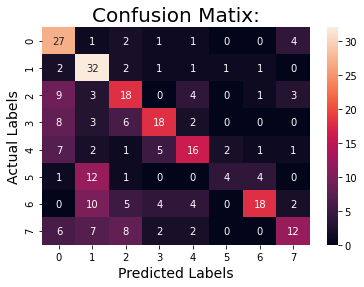

In [401]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(cm)
sns.heatmap(df_cm,annot=True,fmt='')
plt.title('Confusion Matix:',size=20)
plt.xlabel('Predicted Labels',size=14)
plt.ylabel('Actual Labels',size=14)
plt.savefig('Initial_Model_SVM_Confusion_matrix.png')
plt.show()

# Save the model

In [402]:
import pickle

pkl_filename = "pickle_model.pkl"
with open(pkl_filename,'wb') as file:
    pickle.dump(ensemble,file)
    
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    
score = pickle_model.score(x_test,y_test)
print("Test score: {0:.2f} %".format(100 * score))
Ypredict = pickle_model.predict(x_test)

Test score: 50.35 %


In [403]:
Ypredict

array(['surprised', 'surprised', 'fearful', 'angry', 'calm', 'happy',
       'fearful', 'disgust', 'calm', 'angry', 'surprised', 'angry',
       'happy', 'fearful', 'disgust', 'angry', 'happy', 'sad', 'angry',
       'neutral', 'disgust', 'angry', 'fearful', 'angry', 'fearful',
       'calm', 'calm', 'disgust', 'fearful', 'angry', 'happy', 'happy',
       'sad', 'sad', 'calm', 'angry', 'disgust', 'disgust', 'surprised',
       'calm', 'disgust', 'calm', 'fearful', 'calm', 'surprised', 'angry',
       'angry', 'angry', 'disgust', 'calm', 'angry', 'calm', 'neutral',
       'calm', 'calm', 'fearful', 'sad', 'calm', 'calm', 'happy',
       'disgust', 'calm', 'sad', 'sad', 'happy', 'disgust', 'angry',
       'disgust', 'calm', 'happy', 'surprised', 'happy', 'calm', 'angry',
       'fearful', 'surprised', 'sad', 'happy', 'disgust', 'calm', 'calm',
       'fearful', 'calm', 'angry', 'sad', 'disgust', 'disgust', 'fearful',
       'angry', 'calm', 'calm', 'calm', 'disgust', 'fearful', 'calm',
 